In [1]:
!nvidia-smi


Wed Jun 26 06:36:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000001:00:00.0 Off |                    0 |
| N/A   36C    P0              43W / 300W |      9MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Load Phi3-V in bnb mode

In [2]:

# Import necessary libraries
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
import torch
from IPython.display import display
import time


# Define model ID
model_id = "microsoft/Phi-3-vision-128k-instruct"

# Load processor
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

# Define BitsAndBytes configuration for 4-bit quantization
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load model with 4-bit quantization and map to CUDA
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    trust_remote_code=True,
    torch_dtype="auto",
    quantization_config=nf4_config,
)

2024-06-24 13:37:46.873485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
Load Phi3-V in FP16 mode

In [3]:
# Import necessary libraries
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
from transformers import BitsAndBytesConfig
import torch
from IPython.display import display
import time


# Define model ID
model_id = "microsoft/Phi-3-vision-128k-instruct"

# Load processor
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)


# Load model with and map to CUDA
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    trust_remote_code=True,
    torch_dtype="auto"
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
def model_inference(messages, path_image):
    
    start_time = time.time()
    
    image = Image.open(path_image)

    # Prepare prompt with image token
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Process prompt and image for model input
    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")

    # Generate text response using model
    generate_ids = model.generate(
        **inputs,
        eos_token_id=processor.tokenizer.eos_token_id,
        max_new_tokens=500,
        do_sample=False,
    )

    # Remove input tokens from generated response
    generate_ids = generate_ids[:, inputs["input_ids"].shape[1] :]

    # Decode generated IDs to text
    response = processor.batch_decode(
        generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0]


    display(image)
    end_time = time.time()
    print("Inference time: {}".format(end_time - start_time))

    # Print the generated response
    print(response)

Inference with Chinese ID card, does not have good result.

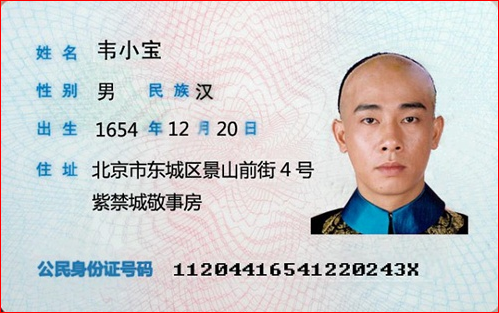

Inference time: 9.615195274353027
{
  "table": [
    {"field": "姓名", "value": "苏小宝"},
    {"field": "性别", "value": "男"},
    {"field": "出生日期", "value": "1654 年12 月20 日"},
    {"field": "民族", "value": "汉"},
    {"field": "住址", "value": "北京市东城区景山前街 4 号"},
    {"field": "公民身份证号码", "value": "11204416541220243X"}
  ]
}
None


In [4]:
prompt_cie_front = [  
    {  
        "role": "user",  
        "content": (  
            "<|image_1|>\n"  
            "Please perform OCR on the image, which is a Chinese ID card.\n"  
            "Extract the following fields and create a JSON table:\n"  
            "Name, Gender, Date of Birth, Ethnicity (e.g., 汉, 满, 回, 蒙古), Full Address, Citizen ID Number.\n"  
            "Ensure that the full address is captured accurately, and check that the name and other details are correctly extracted.\n"  
            "For example:\n"  
            "{\n"  
            "  \"table\": [\n"  
            "    {\"field\": \"姓名\", \"value\": \"\"},\n"  
            "    {\"field\": \"性别\", \"value\": \"\"},\n"  
            "    {\"field\": \"出生日期\", \"value\": \"\"},\n"  
            "    {\"field\": \"民族\", \"value\": \"\"},\n"  
            "    {\"field\": \"住址\", \"value\": \"\"},\n"  
            "    {\"field\": \"公民身份证号码\", \"value\": \"\"}\n"  
            "  ]\n"  
            "}\n"  
            "Make sure the JSON format is correct and the field names and values are accurate."  
        )  
    }  
]  

  
# Download image from URL  
path_image = "/root/1.png"  
  
# Perform inference  
result = model_inference(prompt_cie_front, path_image)  

  
# Print the result  
print(result)  


In [ ]:
Inference with US passport, has good result.

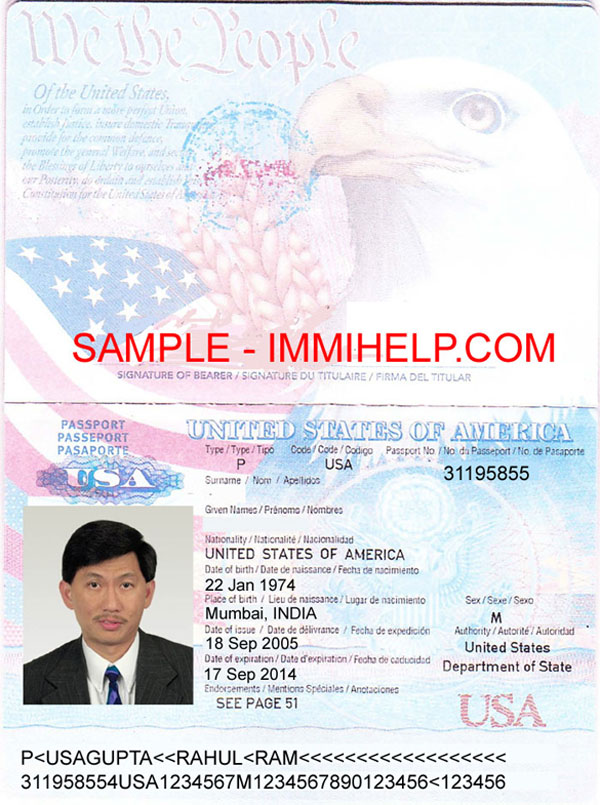

Inference time: 8.578864812850952
{
  'Type / Type / Tipo': 'P',
  'Code / Code / Código': '31195855',
  'Passport No. / No de passeport / Pasaporte n.º': '31195855',
  'Surname / Nom / Apellido': 'Given Name / Prénom / Nombre',
  'Given Names / Prénom / Nombre': 'Mumbai, INDIA',
  'Nationality / Nationalité / Nacionalidad': 'UNITED STATES OF AMERICA',
  'Date of birth / Date de naissance / Fecha de nacimiento': '22 Jan 1974',
  'Place of birth / Lieu de naissance / Lugar de nacimiento': 'Mumbai, INDIA',
  'Date of issue / Date de délivrance / Fecha de expedición': '18 Sep 2005',
  'Date of expiration / Date d'expiration / Fecha de vencimiento': '17 Sep 2014',
  'Sex / Sexe / Sexo': 'M',
  'Authority / Autorité / Autoridad': 'United States Department of State',
  'Endorsements / Mentions / Anotaciones': 'SEE PAGE 51'
}


In [6]:
prompt_cie_front = [  
    {  
        "role": "user",  
        "content": "<|image_1|>\nOCR the text of the image. Extract the text of the following fields and put it in a JSON format: \n{\n  'Type / Type / Tipo': '',\n  'Code / Code / Código': '',\n  'Passport No. / No de passeport / Pasaporte n.º': '',\n  'Surname / Nom / Apellido': '',\n  'Given Names / Prénom / Nombre': '',\n  'Nationality / Nationalité / Nacionalidad': '',\n  'Date of birth / Date de naissance / Fecha de nacimiento': '',\n  'Place of birth / Lieu de naissance / Lugar de nacimiento': '',\n  'Date of issue / Date de délivrance / Fecha de expedición': '',\n  'Date of expiration / Date d'expiration / Fecha de vencimiento': '',\n  'Sex / Sexe / Sexo': '',\n  'Authority / Autorité / Autoridad': '',\n  'Endorsements / Mentions / Anotaciones': ''\n}"  
    }  
]  


# Download image from URL
path_image = "/root/usa-passport.jpg"

# inference
model_inference(prompt_cie_front, path_image)

## Inference with a picture from a traffic vedio, has good result.

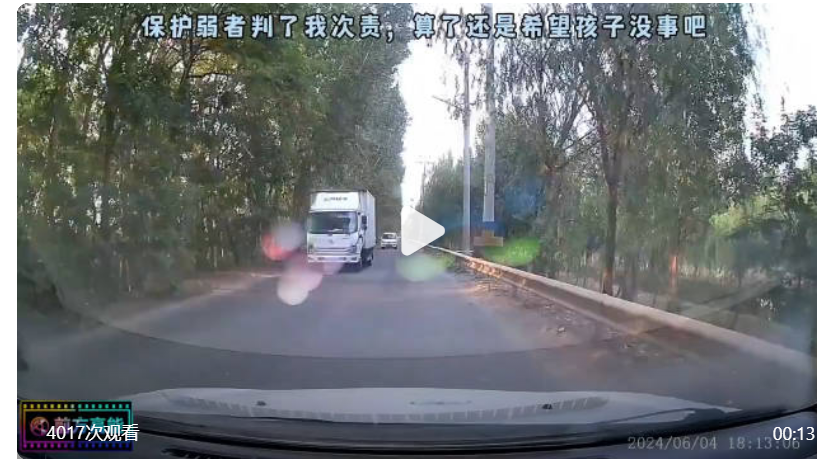

Inference time: 4.671922445297241
The image shows a white truck driving on a road with trees on both sides. There is a car in front of the truck, and the truck appears to be in motion. The road seems to be in a rural or less-traveled area. There is no immediate indication of danger, but the truck's position and the car's proximity suggest caution is advisable.
None


In [5]:
prompt_cie_front = [  
    {  
        "role": "user",  
        "content": (  
            "<|image_1|>\n"  
            "Please describe the image and then analyze whether there is a danger.\n"  
        )  
    }  
]  

  
# Download image from URL  
path_image = "/root/777.png"  
  
# Perform inference  
result = model_inference(prompt_cie_front, path_image)  

  
# Print the result  
print(result)  


In [ ]:
Phi3-Vision-128k-Instruct inference with vLLM on H100

In [1]:
import os  
import time  
from PIL import Image  
from vllm import LLM, SamplingParams  
from vllm.multimodal.image import ImagePixelData  
  
def load_model():  
    model_path = "microsoft/Phi-3-vision-128k-instruct"  
    llm = LLM(  
        model=model_path,  
        trust_remote_code=True,  
        image_input_type="pixel_values",  
        image_token_id=32044,  
        image_input_shape="1,3,1008,1344",  
        max_model_len=4096,
        gpu_memory_utilization=0.2,
        image_feature_size=1921,  
        disable_image_processor=False,  
    )  
    return llm  
  
def perform_inference(llm, image_path):  
    image = Image.open(image_path)  
    # single-image prompt  
    prompt = (  
        "<|user|>\n<|image_1|>\nOCR the text of the image. Extract the text of the following fields and put it in a JSON format: \n"  
        "{\n"  
        "  'Type / Type / Tipo': '',\n"  
        "  'Code / Code / Código': '',\n"  
        "  'Passport No. / No de passeport / Pasaporte n.º': '',\n"  
        "  'Surname / Nom / Apellido': '',\n"  
        "  'Given Names / Prénom / Nombre': '',\n"  
        "  'Nationality / Nationalité / Nacionalidad': '',\n"  
        "  'Date of birth / Date de naissance / Fecha de nacimiento': '',\n"  
        "  'Place of birth / Lieu de naissance / Lugar de nacimiento': '',\n"  
        "  'Date of issue / Date de délivrance / Fecha de expedición': '',\n"  
        "  'Date of expiration / Date d'expiration / Fecha de vencimiento': '',\n"  
        "  'Sex / Sexe / Sexo': '',\n"  
        "  'Authority / Autorité / Autoridad': '',\n"  
        "  'Endorsements / Mentions / Anotaciones': ''\n"  
        "}\n<|end|>\n<|assistant|>\n"  
    )  
    prompt = prompt.replace("<|image_1|>", "<|image|>" * 1921 + "<s>")  
    sampling_params = SamplingParams(temperature=0, max_tokens=512)  
      
    start_time = time.time()  # 记录推理开始时间  
    outputs = llm.generate(  
        {  
            "prompt": prompt,  
            "multi_modal_data": ImagePixelData(image),  
        },  
        sampling_params=sampling_params  
    )  
    end_time = time.time()  # 记录推理结束时间  
      
    inference_time = end_time - start_time  
    print(f"Inference time: {inference_time:.2f} seconds")  
      
    for o in outputs:  
        generated_text = o.outputs[0].text  
        print(generated_text)  
  
if __name__ == "__main__":  
    image_path = "/root/usa-passport.jpg"  # 修改为你的本地图片路径  
    llm = load_model()  
    perform_inference(llm, image_path)  


/opt/miniconda/envs/vllm-phi3v/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


INFO 06-27 01:51:56 llm_engine.py:164] Initializing an LLM engine (v0.5.0.post1) with config: model='microsoft/Phi-3-vision-128k-instruct', speculative_config=None, tokenizer='microsoft/Phi-3-vision-128k-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None), seed=0, served_model_name=microsoft/Phi-3-vision-128k-instruct)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 06-27 01:51:56 selector.py:161] Cannot use FlashAttention-2 backend due to sliding window.
INFO 06-27 01:51:56 selector.py:52] Using XFormers backend.
INFO 06-27 01:51:57 selector.py:161] Cannot use FlashAttention-2 backend due to sliding window.
INFO 06-27 01:51:57 selector.py:52] Using XFormers backend.


[rank0]:[W ProcessGroupGloo.cpp:721] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())


INFO 06-27 01:51:57 weight_utils.py:218] Using model weights format ['*.safetensors']
INFO 06-27 01:51:58 model_runner.py:224] Loading model weights took 7.7732 GB
INFO 06-27 01:51:59 gpu_executor.py:83] # GPU blocks: 1753, # CPU blocks: 682
INFO 06-27 01:52:00 model_runner.py:845] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 06-27 01:52:00 model_runner.py:849] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 06-27 01:52:09 model_runner.py:921] Graph capturing finished in 9 secs.


Processed prompts:   0%|                      | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 06-27 01:52:09 phi3v.py:322] Dynamic image shape is currently not supported. Resizing input image to (1344, 1008).


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it, est. speed input: 737.22 toks/s, output: 109.73 toks/s]

Inference time: 2.96 seconds
 ```json
{
  "Type / Type / Tipo": "P",
  "Code / Code / Código": "31195855",
  "Passport No. / No de passeport / Pasaporte n.º": "31195855",
  "Surname / Nom / Apellido": "Given Name / Prénom / Nombre",
  "Given Names / Prénom / Nombre": "Given Name / Prénom / Nombre",
  "Nationality / Nationalité / Nacionalidad": "UNITED STATES OF AMERICA",
  "Date of birth / Date de naissance / Fecha de nacimiento": "22 Jan 1974",
  "Place of birth / Lieu de naissance / Lugar de nacimiento": "Mumbai, INDIA",
  "Date of issue / Date de délivrance / Fecha de expedición": "18 Sep 2005",
  "Date of expiration / Date d'expiration / Fecha de vencimiento": "17 Sep 2014",
  "Sex / Sexe / Sexo": "M",
  "Authority / Autorité / Autoridad": "United States Department of State",
  "Endorsements / Mentions / Anotaciones": "SEE PAGE 51"
}
```
